# Temporal-difference

In [20]:
import numpy as np
import os, sys
import pprint
pp = pprint.PrettyPrinter(indent=2)
from collections import defaultdict

sys.path.insert(
    1,
    os.path.realpath(
        os.path.join(os.path.pardir, "reinforcement-learning-exercises")
    )
)

from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting
import matplotlib
matplotlib.style.use('ggplot')

In [21]:
env = WindyGridworldEnv()

## Sarsa

In [22]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        best_value = np.amax(Q[observation])
        best_action = list(Q[observation]).index(best_value)
        probs = np.ones(nA) * epsilon / nA
        probs[best_action] = 1 - epsilon + epsilon / nA
        return probs
    
    return policy_fn

In [23]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        observation = env.reset()
        probs = policy(observation)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        for t in range(100):
            new_observation, reward, done, _ = env.step(action)
            probs = policy(new_observation)
            new_action = np.random.choice(np.arange(len(probs)), p=probs)
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            Q[observation][action] += alpha * (
                reward + discount_factor * Q[new_observation][new_action] - Q[observation][action]
            )
            observation = new_observation
            action = new_action
            
            if done:
                break
    
    return Q, stats

In [24]:
Q, stats = sarsa(env, 200)

Episode 200/200.

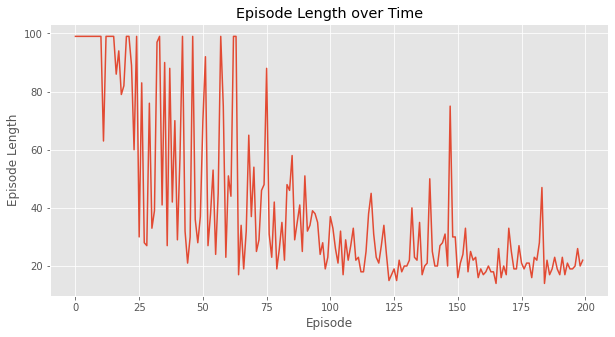

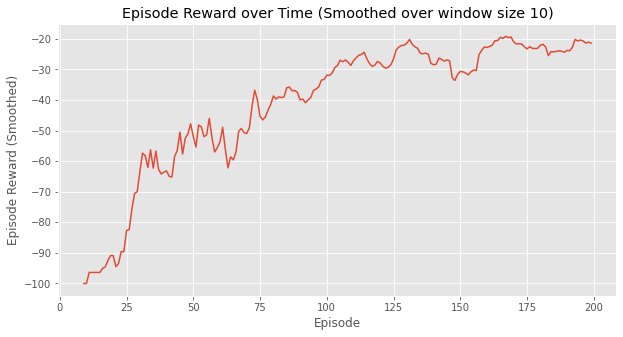

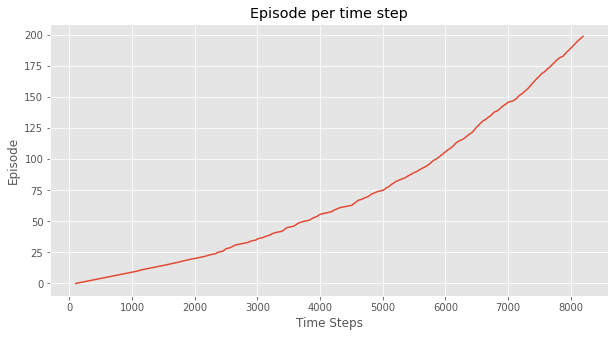

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [25]:
plotting.plot_episode_stats(stats)

## Q-learning

In [26]:
from lib.envs.cliff_walking import CliffWalkingEnv
env = CliffWalkingEnv()

In [30]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        observation = env.reset()
        probs = policy(observation)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        for t in range(100):
            new_observation, reward, done, _ = env.step(action)
            probs = policy(new_observation)
            new_action = np.random.choice(np.arange(len(probs)), p=probs)
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            best_action = np.argmax(Q[new_observation])
            Q[observation][action] += alpha * (
                reward + discount_factor * Q[new_observation][best_action] - Q[observation][action]
            )
            observation = new_observation
            action = new_action
            
            if done:
                break
    
    return Q, stats

In [31]:
Q, stats = q_learning(env, 500)

Episode 500/500.

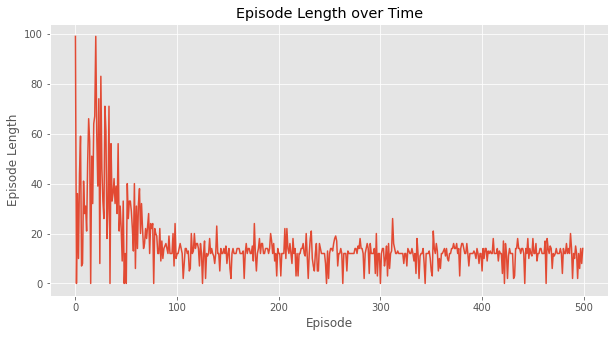

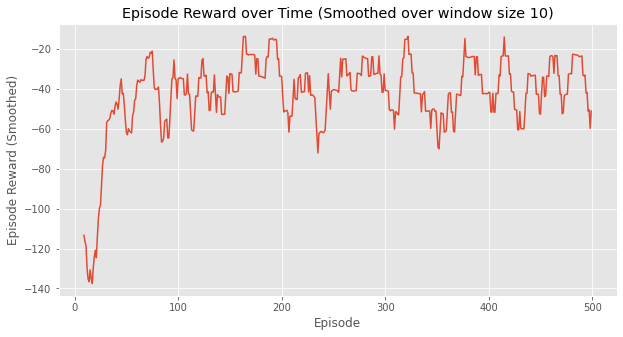

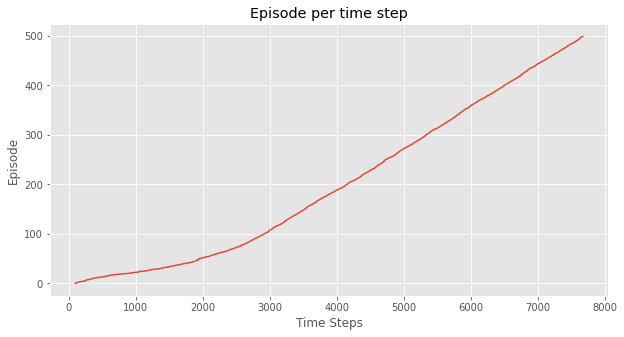

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [32]:
plotting.plot_episode_stats(stats)